Whenever a setup cell is modified, it must be rerun for the change to be reflected in calls to model functions.

## Setup: Modules

These are the bare minimum models required to run the code in this example notebook.  Feel free to add more if you modify this notebook (for example, if you want to manually make some custom plots, you would likely import matplotlib).

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import ALS

## Setup: User Model

Must instantiate KineticModel object after defining user model.

In [9]:
from ex_model_1 import model_H2O2_depletion
model = ALS.KineticModel(model_H2O2_depletion)

## Setup: Species Data

Step 1:

In [302]:
tbin = 10                    # tbin used when data was loaded from Igor
t_start = -20                # Trim the data to t_start inclusive (ms)
t_end = 59.8                 # Trim the data to t_end inclusive (ms)
fn_val = 'ex_data_val_1.csv' # Filename for the data values
fn_err = 'ex_data_err_1.csv' # Filename for the error in the data

dt = 0.02                    # Fundaemental kinetic time step (ms)
t = np.linspace(-20,130,num=int(150/(dt*tbin)),endpoint=False)

df_val = pd.read_csv(fn_val)
df_err = pd.read_csv(fn_err)

idx_start = np.abs(t-t_start).argmin()
idx_end = np.abs(t-t_end).argmin()
drop_indices = np.concatenate((np.arange(idx_start),np.arange(idx_end+1,t.size)))

t = t[idx_start:idx_end+1]
df_val = df_val.drop(drop_indices, axis=0).reset_index(drop=True)
df_err = df_err.drop(drop_indices, axis=0).reset_index(drop=True)

Step 2:

In [303]:
data = {}
data['H2O2'] = {'val':df_val['H2O2'].values, 'err':df_err['H2O2'].values, 'fit':True, 'weight':1}
data['HO2']  = {'val':df_val['HO2'].values,  'err':df_err['HO2'].values,  'fit':True, 'weight':1}
data['OH']   = {'val':df_val['OH'].values,   'err':df_err['OH'].values,   'fit':True, 'weight':1}
data = pd.DataFrame.from_dict(data, orient='index')
display(data)

,val,err,fit,weight
H2O2,"[6135.0, 6162.0, 6025.0, 6005.0, 6027.0, 6101....","[78.326, 78.498, 77.621, 77.492, 77.634, 78.10...",True,1
HO2,"[-3.15, -4.15, -3.15, -4.15, 5.85, 6.85, -1.15...","[5.0, 4.899, 5.0, 4.899, 5.831, 5.9161, 5.1962...",True,1
OH,"[-0.82, 0.18, 0.18, -0.82, -0.82, -0.82, 1.18,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.4142, 1.0, 1....",True,1


## Setup: Model and ALS Parameters

In [305]:
c_H2O2_0 = 3.25e14
idx_zero = np.abs(t-(-1.68)).argmin()
S_H2O2 = df_val.iloc[:idx_zero,df_val.columns.get_loc('H2O2')].mean() / c_H2O2_0

model_params = {}
model_params['X0'] =         {'val':4.0e12,     'err':0,  'fit':True}
model_params['k_OH_wall'] =  {'val':20.,        'err':0, 'fit':True}
model_params['k_HO2_wall'] = {'val':10.,        'err':0, 'fit':True}
model_params['T'] =          {'val':298.,       'err':0,  'fit':False}
model_params['P'] =          {'val':30.,        'err':0,  'fit':False}
model_params['c_H2O2_0'] =   {'val':c_H2O2_0,   'err':0,  'fit':False}
model_params = pd.DataFrame.from_dict(model_params, orient='index')

print('Inputted Model Params:')
display(model_params)

ALS_params = {}
ALS_params['S_H2O2'] =  {'val':S_H2O2,    'err':0, 'fit':False}
ALS_params['S_OH'] =    {'val':5e-14,     'err':0, 'fit':True}
ALS_params['S_HO2'] =   {'val':5e-14,     'err':0, 'fit':True}
ALS_params['A'] =       {'val':-3.76e-1,  'err':0, 'fit':False}
ALS_params['B'] =       {'val':4.85e-3,   'err':0, 'fit':False}
ALS_params['t0'] =      {'val':-1.68,     'err':0, 'fit':False}
ALS_params = pd.DataFrame.from_dict(ALS_params, orient='index')

print('Inputted ALS Params:')
display(ALS_params)

Inputted Model Params:


,val,err,fit
P,3.000000e+01,0,False
T,2.980000e+02,0,False
X0,4.000000e+12,0,True
c_H2O2_0,3.250000e+14,0,False
k_HO2_wall,1.000000e+01,0,True
k_OH_wall,2.000000e+01,0,True


Inputted ALS Params:


,val,err,fit
A,-3.760000e-01,0,False
B,4.850000e-03,0,False
S_H2O2,1.857629e-11,0,False
S_HO2,5.000000e-14,0,True
S_OH,5.000000e-14,0,True
t0,-1.680000e+00,0,False


## Perform a fit

Optimization terminated successfully.
Exit Code = 2
Exit Message = The relative error between two consecutive iterates is at most 0.000000

Optimized Cost Function Value = 4.54077e+06

Optimized Parameters and Standard Errors:


,val,err
X0,4.070990e+12,1.268503e+11
k_HO2_wall,7.637880e-02,8.214932e-03
k_OH_wall,2.132858e+01,2.078935e+00
S_HO2,2.716717e-10,5.293597e-12
S_OH,3.010368e-11,1.325424e-11



Correlation Matrix:


,X0,k_HO2_wall,k_OH_wall,S_HO2,S_OH
X0,1.000000,0.071755,-0.039849,-0.925403,-0.051266
k_HO2_wall,0.071755,1.000000,-0.138262,-0.119720,-0.001090
k_OH_wall,-0.039849,-0.138262,1.000000,0.022242,-0.003146
S_HO2,-0.925403,-0.119720,0.022242,1.000000,0.047411
S_OH,-0.051266,-0.001090,-0.003146,0.047411,1.000000


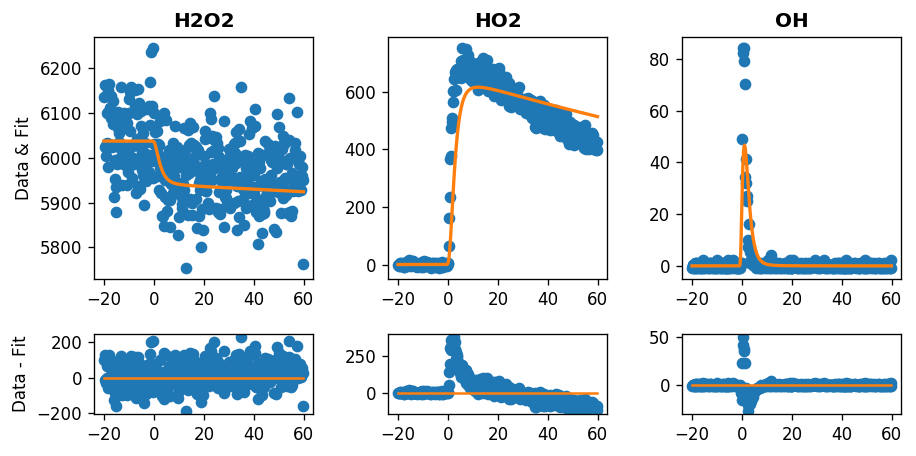

In [307]:
df_p, df_cov_p, df_corr_p, cost, mesg, ier \
    = model.fit(t, tbin, data, model_params, ALS_params, err_weight=False)

## Plot the data overlaid with the scaled model

Important: Despite the plot_fit name, this function does not actually perform a fit.


Use cases:
1. plotting a previous fit without having to rerun the fit code\n
2. playing around with initial guesses before performing a fit\n
3. saving optimized model * scale factor for each species in order to plot elsewere

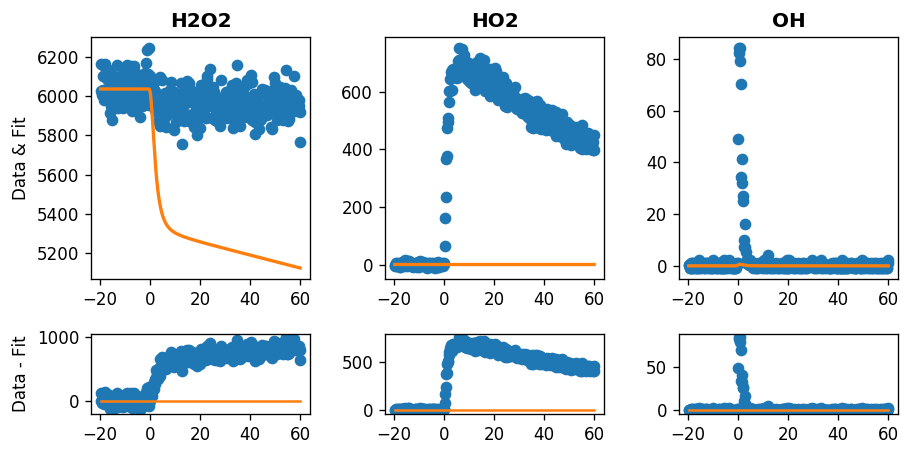

In [295]:
model.plot_fit(t, tbin, data, model_params, ALS_params)

In [296]:
import importlib
importlib.reload(ALS)
model = ALS.KineticModel(model_H2O2_depletion)